**deepSIMO**<br>
by $\text{Rishabh Pomaje}$

- Autoencoder based SIMO system with perfect CSI available exclusively at the receiver.
- Objectives :
    - To learn a (4, 7) system under the following conditions :
    1. Flat-fading, fast fading 
    2. Rayleigh Channel with AWGN 
    3. Channel Model: $y_i = h_i x_i + w_i$
        - where, $h \overset{i.i.d}{\sim} \mathcal{CN}(0, 1)$ and $w \overset{i.i.d}{\sim} \mathcal{CN}(0, N_0)$

**Definitions**
\begin{equation}
    \text{SNR}_{linear} = \text{Signal-to-noise power ratio per symbol time} = \frac{E_b}{2N_0}
\end{equation}
Consider,
\begin{equation*}
    \frac{1}{2 \times SNR_{linear}} = \frac{1 \times 2N_0}{2 \times E_b} = \frac{N_0}{a} = N_0 \;\dots (a = 1) 
\end{equation*}

Also, 

\begin{equation*}
\frac{1}{2 \times R \times SNR_{linear}} = \frac{1 \times n \times N_0}{2 \times k \times E_b} = \frac{nN_0}{2k}
\end{equation*}

In [30]:
# Dependencies :
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
import time
t0 = time.time()
%config InlineBackend.figure_format='svg'
TF_ENABLE_ONEDNN_OPTS = 0 
print(tf.__version__)

2.16.1


- We are restraining to using only BPSK mapping
We define SNR as follows :
\begin{equation}
\text{SNR}_{linear} = \frac{E_b}{N_0} = \frac{\text{Received signal energy per bit}}{\text{Noise Spectral density}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1 $
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

- System Specifications/ Parameters and Constants 

In [31]:
k = 4       # Number of bits to be encoded
n = 7       # Size of the codeword 
M = 2 ** k  # Size of the alphabet
R = k / n   # Information rate

- Generation of training data

In [32]:
training_set_size = 10 ** 6

# Random indices :
sample_indices = np.random.randint(0, M, training_set_size)

# Converting to 1-hot encoded vectors 
x_train = np.zeros((training_set_size, M))
x_train[np.arange(training_set_size), sample_indices] = 1 

print(f'Samples = {x_train}')
y_train = x_train

# Generate random fading taps for training :: CSI @ Rx
fade_mean = 0 
fade_std = np.sqrt(0.5)
fading_taps_real = np.random.normal(fade_mean, fade_std, (training_set_size, 2*n))
fading_taps_imag = np.random.normal(fade_mean, fade_std, (training_set_size, 2*n))

Samples = [[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


- Creating the Autoencoder

In [33]:
# Custom layer definition(s) 
import tensorflow as tf

class DuplicateLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DuplicateLayer, self).__init__()

    def call(self, inputs):
        return tf.concat([inputs, inputs], axis=-1)

# Test the custom layer
input_data = tf.constant([[1, 2, 3]], dtype=tf.float32)
custom_layer = DuplicateLayer()
output_data = custom_layer(input_data)
print(output_data)

tf.Tensor([[1. 2. 3. 1. 2. 3.]], shape=(1, 6), dtype=float32)


In [34]:
# Description of the encoder(== transmitter) part :
enc_input_layer_bits = tf.keras.Input(shape=(M, ), name="Input_Layer")
fading_layer_I = tf.keras.Input(shape=(2*n, ), name='fading_taps_I')
fading_layer_Q = tf.keras.Input(shape=(2*n, ), name='fading_taps_Q')

enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name="Enc_Hidden_Layer_01")(enc_input_layer_bits)
enc_layer_02 = tf.keras.layers.Dense(n, activation='relu', name="Enc_Hidden_Layer_02")(enc_layer_01)
enc_layer_03 = tf.keras.layers.Dense(n, activation='linear', name="Enc_Hidden_Layer_03")(enc_layer_02)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)), name='Power_Constraint')(enc_layer_03)

# Two paths of antenna 01 and antenna 02 :: by duplicating the output of the encoder || Antenna 01 | Antenna 02 ||
signal_01_02 = DuplicateLayer()(enc_layer_normalized)

# Describing the channel part :
# y = fx + w  model(flat + fast fading):
faded_signal_I = tf.keras.layers.Multiply()([signal_01_02, fading_layer_I])
faded_signal_Q = tf.keras.layers.Multiply()([signal_01_02, fading_layer_Q])
# Adding the All-White-Gaussian-Noise :
SNR_train = float(input('Enter training SNR'))
SNR_lin = 10 ** (SNR_train / 10)
rx_noisy_signal_I = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_I')(faded_signal_I)
rx_noisy_signal_Q = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel_Q')(faded_signal_Q)

# Description of the Decoder (==Receiver) part :
rx_signal = tf.keras.layers.Concatenate()([rx_noisy_signal_I, rx_noisy_signal_Q, fading_layer_I, fading_layer_Q])
dec_layer_01 = tf.keras.layers.Dense(8*n, activation='relu', name='Decoder_Hidden_01')(rx_signal)
dec_layer_02 = tf.keras.layers.Dense(2*M, activation='relu', name='Decoder_Hidden_02')(dec_layer_01)
dec_layer_03 = tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_03')(dec_layer_02)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_03)

autoencoder = tf.keras.Model(
                    inputs = [enc_input_layer_bits, fading_layer_I, fading_layer_Q], 
                    outputs = [dec_output_layer],
                )

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_01 │ (None, 16)        │        272 │ Input_Layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_02 │ (None, 7)         │        119 │ Enc_Hidden_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Enc_Hidden_Layer_03 │ (None, 7)         │         56 │ Enc_Hidden_Layer… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Power_Constraint    │ (None, 7)         │          0 │ Enc_Hidden_Layer… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duplicate_layer_5   │ (None, 14)        │          0 │ Power_Constraint… │
│ (DuplicateLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_I       │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fading_taps_Q       │ (None, 14)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 14)        │          0 │ duplicate_layer_… │
│ (Multiply)          │                   │            │ fading_taps_I[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_5          │ (None, 14)        │          0 │ duplicate_layer_… │
│ (Multiply)          │                   │            │ fading_taps_Q[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_I      │ (None, 14)        │          0 │ multiply_4[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ AWGN_channel_Q      │ (None, 14)        │          0 │ multiply_5[0][0]  │
│ (GaussianNoise)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 56)        │          0 │ AWGN_channel_I[0… │
│ (Concatenate)       │                   │            │ AWGN_channel_Q[0… │
│                     │                   │            │ fading_taps_I[0]… │
│                     │                   │            │ fading_taps_Q[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_01   │ (None, 56)        │      3,192 │ concatenate_2[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_02   │ (None, 32)        │      1,824 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Hidden_03   │ (None, 16)        │        528 │ Decoder_Hidden_0… │
│ (Dense)             │                   │            │                 

 Total params: 6,263 (24.46 KB)

 Trainable params: 6,263 (24.46 KB)

 Non-trainable params: 0 (0.00 B)

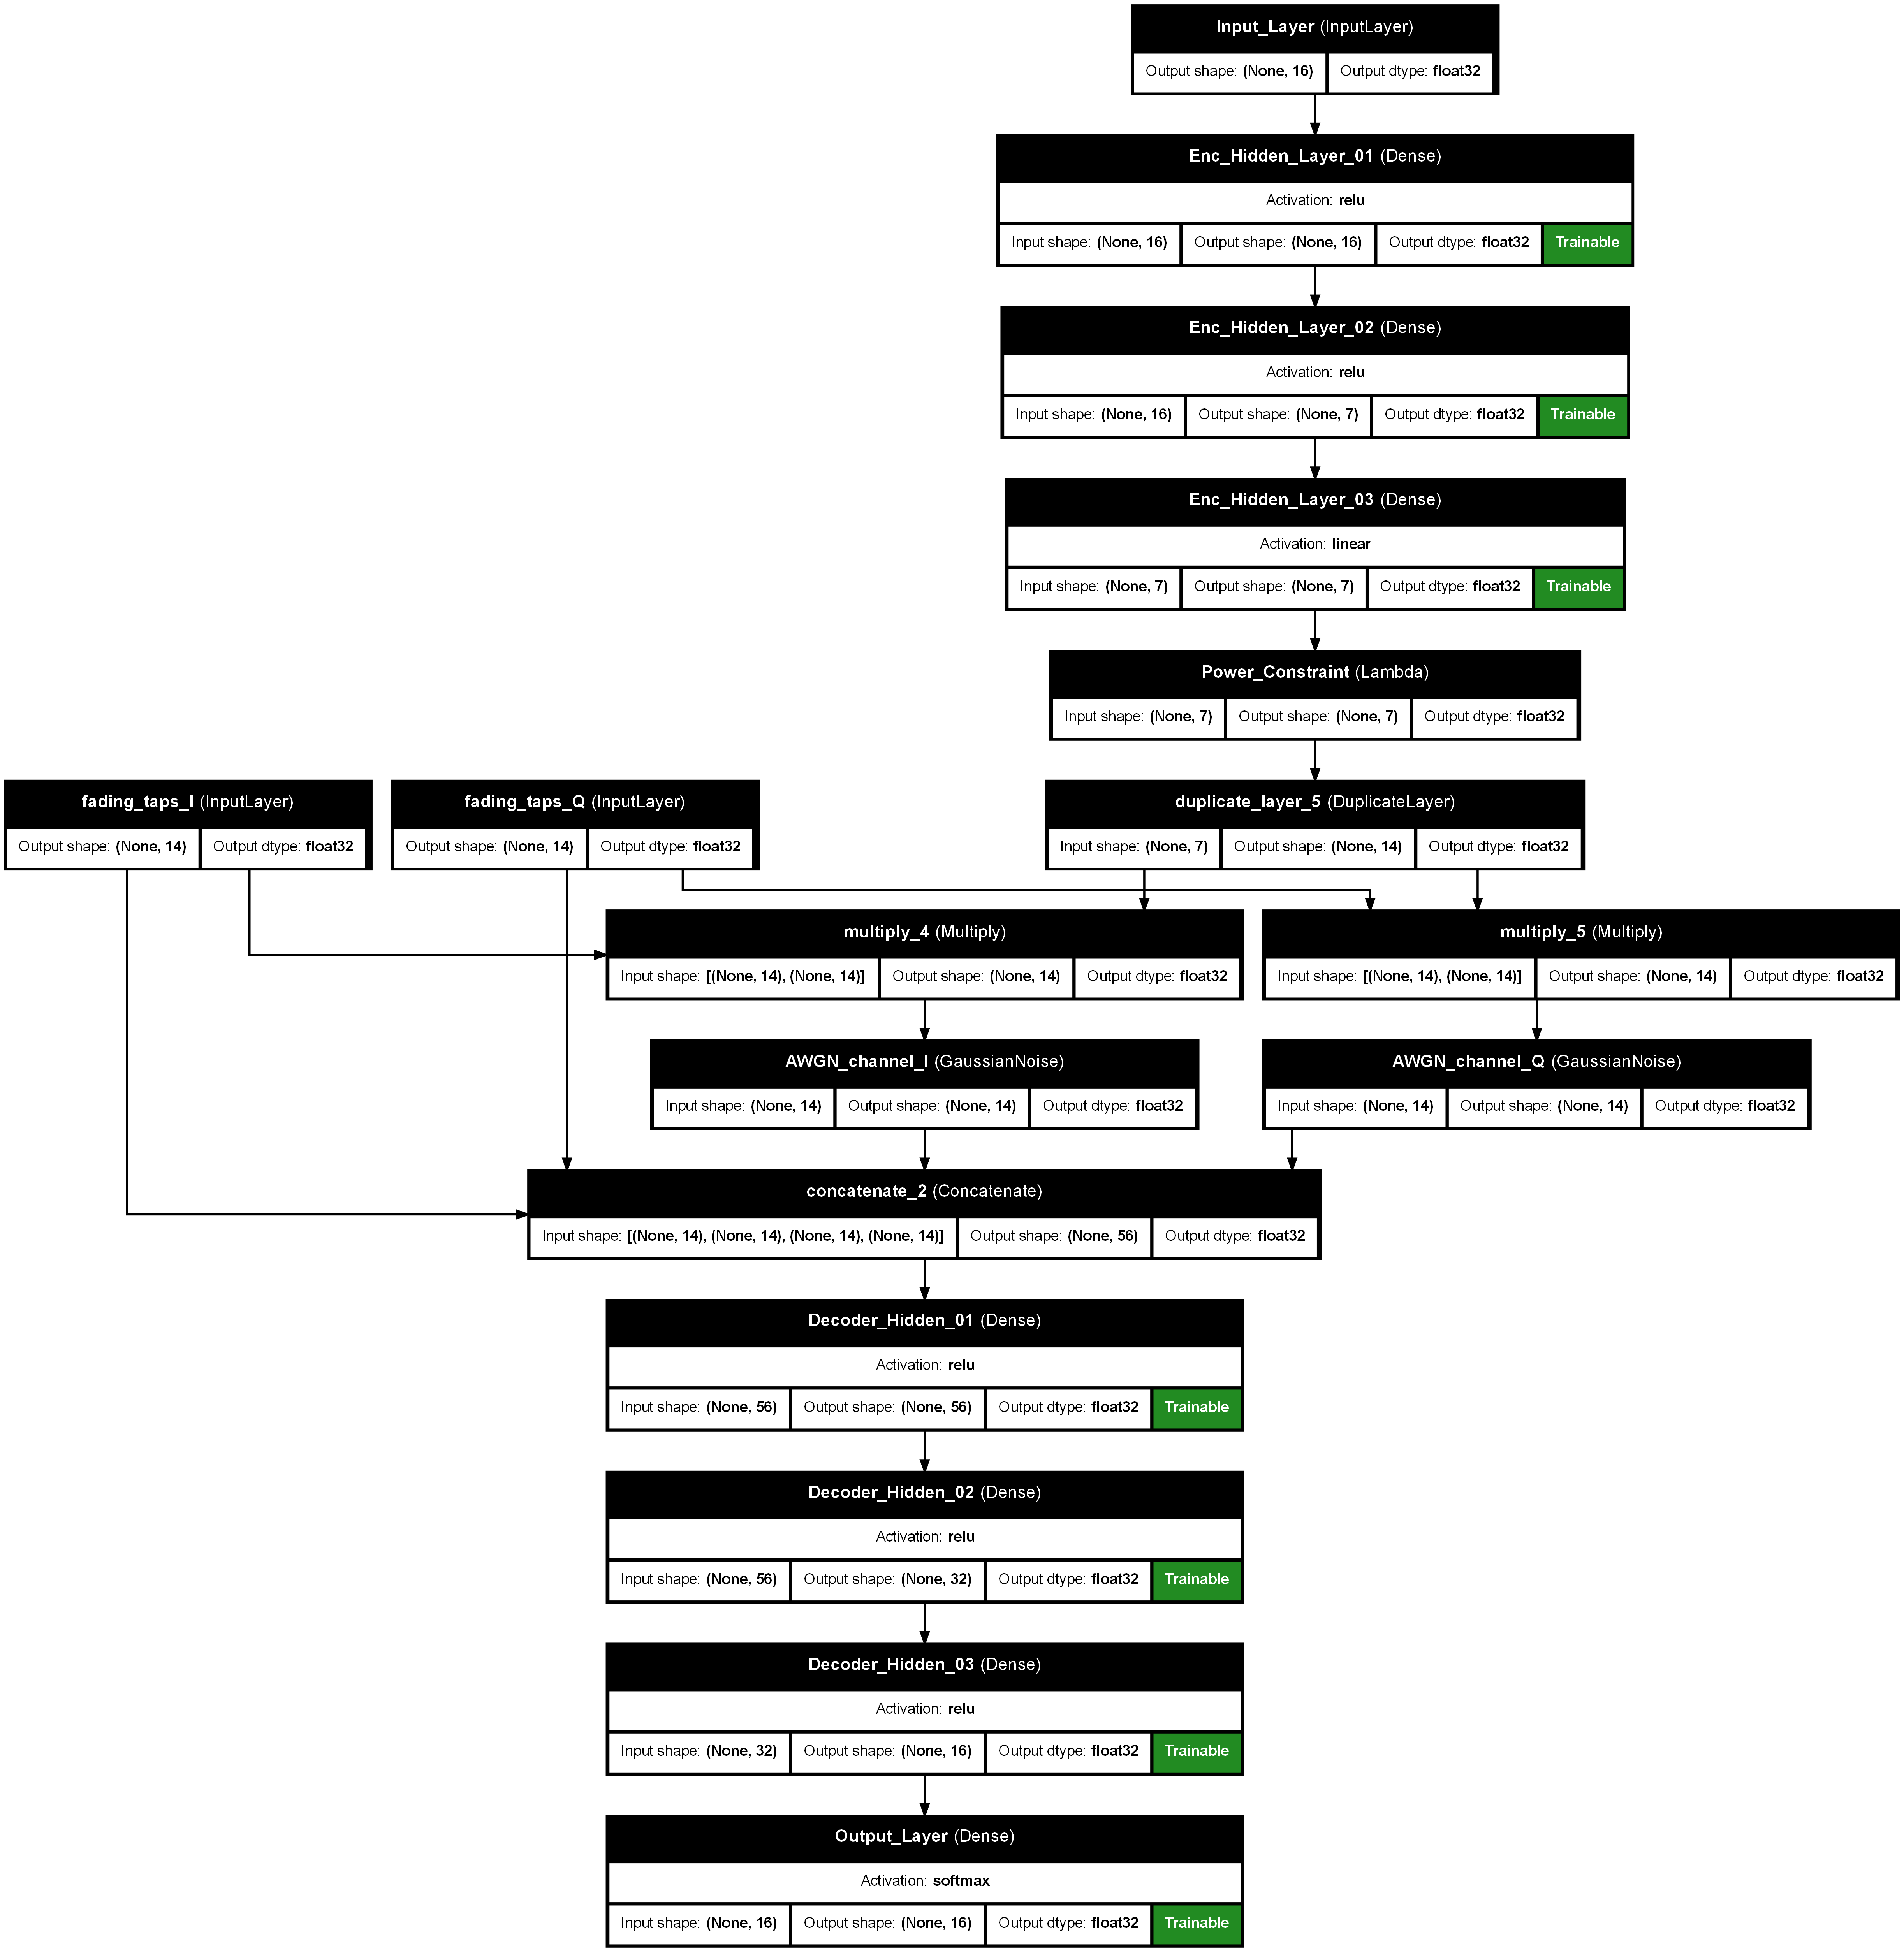

In [35]:
tf.keras.utils.plot_model(
    autoencoder,
    to_file='images/deepSIMO.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True,
)

- Training the autoencoder

In [36]:
autoencoder.fit([x_train, fading_taps_real, fading_taps_imag], y_train, batch_size=10 ** 3, epochs=250)

Epoch 1/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.4727 - loss: 1.5148
Epoch 2/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9695 - loss: 0.0916
Epoch 3/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9870 - loss: 0.0391
Epoch 4/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9930 - loss: 0.0212
Epoch 5/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9957 - loss: 0.0133
Epoch 6/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - accuracy: 0.9971 - loss: 0.0090
Epoch 7/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.9978 - loss: 0.0068
Epoch 8/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.9982 - loss: 0.0055
Epoch 9/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.9987 - loss: 0.0042
Epoch 10/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.9988 - loss: 0.0037
Epoch 11/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9988 - loss: 0.0034
Epoch 1

In [37]:
t1 = time.time()

- Testing the above learnt system

Generation of testing/ validation data 


In [38]:
testing_set_size = 10 ** 6

# Random samples :
y_test = np.random.randint(0, M, testing_set_size)

# 1 hot encoded vectors 
x_test = np.zeros((testing_set_size, M))
x_test[np.arange(testing_set_size), y_test] = 1
print(x_test)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


- Abstracting the encoder and decoder for separate operations

In [39]:
# Encoder 
encoder_model = tf.keras.Model(enc_input_layer_bits, signal_01_02)

# Decoder model 
signal_rx_real = tf.keras.Input(shape=(2*n, ))
signal_rx_imag = tf.keras.Input(shape=(2*n, ))
csi_real = tf.keras.Input(shape=(2*n, ))
csi_imag = tf.keras.Input(shape=(2*n, ))
decoder_output = autoencoder.layers[-5]([signal_rx_real, signal_rx_imag, csi_real, csi_imag])
decoder_output = autoencoder.layers[-4](decoder_output)
decoder_output = autoencoder.layers[-3](decoder_output)
decoder_output = autoencoder.layers[-2](decoder_output)
decoder_output = autoencoder.layers[-1](decoder_output)

decoder_model = tf.keras.Model([signal_rx_real, signal_rx_imag, csi_real, csi_imag], decoder_output)

- Validation Routine

In [40]:
# Range of Signal to Noise Ratio :
# in dB :
SNR_dB = np.linspace(-2, 20, 30)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) 

In [41]:
BLER_learned_simo_csir = []
for noise in noise_var :
    # Encoding 
    encoded_signal = encoder_model.predict(x_test)
    # Fading 
    fade_taps = np.random.normal(fade_mean, fade_std, (testing_set_size, 2*n)) + 1j* np.random.normal(0, fade_std, (testing_set_size, 2*n))
    rx_faded_signal = fade_taps * encoded_signal
    # Noise
    noise_samples = np.random.normal(0, np.sqrt(noise), (testing_set_size, 2*n)) + 1j* np.random.normal(0, np.sqrt(noise), (testing_set_size, 2*n))
    rx_noisy_signal = rx_faded_signal + noise_samples 
    # Decoding 
    decoded_signal = decoder_model.predict([np.real(rx_noisy_signal), np.imag(rx_noisy_signal), np.real(fade_taps), np.imag(fade_taps)])
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned_simo_csir.append(np.sum(estimated_vectors != y_test) / testing_set_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 118s 4ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 153s 5ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 102s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 150s 5ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 141s 5ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 58s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 234s 7ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 207s 7ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 310s 10ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 112s 4ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 246s 8ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 111s 4ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 20s 648us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 890us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 29s 942us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 902us/step
31250/31250 ━━

In [42]:
print(f'BLER_learned_simo_csir = {BLER_learned_simo_csir}')

BLER_learned_simo_csir = [0.68087, 0.635825, 0.585032, 0.526666, 0.464203, 0.398273, 0.330631, 0.264019, 0.202308, 0.149625, 0.105536, 0.070363, 0.044571, 0.027296, 0.015705, 0.008723, 0.0048, 0.002403, 0.001276, 0.000649, 0.000336, 0.000162, 0.000104, 6.1e-05, 4.3e-05, 3.5e-05, 2e-05, 2.4e-05, 1.6e-05, 1.3e-05]


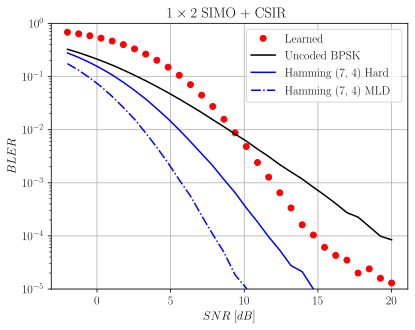

In [43]:
plt.rcParams.update({
    "text.usetex": True, # Comment this if TeX is not available in your machine
    "font.family" : 'serif',
    "font.size": 12
})
fig, axes = plt.subplots()
BLER_uncoded_mrc = [0.3253992, 0.2808952, 0.2380436, 0.198924, 0.1637788, 0.1324848, 0.1054372, 0.0830536, 0.064546, 0.0495912, 0.0375792, 0.0281424, 0.021, 0.0153624, 0.011326, 0.0082344, 0.006082, 0.0043064, 0.0031212, 0.00219, 0.0015984, 0.0011776, 0.000824, 0.0005848, 0.0004056, 0.0002744, 0.0002256, 0.0001496, 9.88e-05, 8.44e-05]
BLER_coded_mrc_hard = [0.2773788, 0.228524, 0.182608, 0.141962, 0.1069448, 0.0776332, 0.054906, 0.0376056, 0.0247236, 0.0159564, 0.0098688, 0.0059584, 0.003524, 0.002086, 0.0011492, 0.0006492, 0.000336, 0.0001836, 9.6e-05, 5.36e-05, 2.76e-05, 2.12e-05, 1e-05, 3.6e-06, 8e-07, 8e-07, 8e-07, 0.0, 0.0, 0.0]
BLER_coded_mrc_mld = [0.1745596, 0.130938, 0.0940804, 0.0646376, 0.0421228, 0.0260892, 0.0156784, 0.0086572, 0.0046156, 0.0023564, 0.001134, 0.0005644, 0.0002416, 0.0001068, 4.92e-05, 1.84e-05, 1.04e-05, 2.8e-06, 8e-07, 0.0, 4e-07, 4e-07, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

axes.semilogy(SNR_dB, BLER_learned_simo_csir, label='Learned', color='red', marker="o", ls=" ")
axes.semilogy(SNR_dB, BLER_uncoded_mrc, label='Uncoded BPSK', color='black')
axes.semilogy(SNR_dB, BLER_coded_mrc_hard, label='Hamming (7, 4) Hard', color='blue')
axes.semilogy(SNR_dB, BLER_coded_mrc_mld, label='Hamming (7, 4) MLD', color='blue', ls="-.")
axes.set_xlabel(r'$SNR\ [dB]$')
axes.set_ylabel(r'$BLER$')
axes.set_ylim(10**-5, 10**0)
# axes.set_xlim(-4, 10)
axes.set_title(r'$1 \times 2$ SIMO + CSIR')
axes.legend()
axes.grid()

In [44]:
# Saving the results for future reference :
# Plots :
fig.savefig(f'plots/deepSIMO_{SNR_train}.svg', transparent=True)
# BLER values :
with open(file=f'results/deepSIMO_{SNR_train}.txt', mode='w') as file_id:
    file_id.write(f'BLER_uncoded_mrc = {BLER_uncoded_mrc}\n')
    file_id.write(f'BLER_coded_mrc_hard = {BLER_coded_mrc_hard}\n')
    file_id.write(f'BLER_coded_mrc_mld = {BLER_coded_mrc_mld}\n')
    file_id.write(f'BLER_learned_simo_csir_{SNR_train} = {BLER_learned_simo_csir}')

In [45]:
print(f'Total Execution time = {time.time() - t0}')
print(f'Training time = {t1 - t0}')
print(f'Testing time = {time.time() - t1}')

Total Execution time = 9299.180812358856
Training time = 3892.03284406662
Testing time = 5407.147968292236
